---
Работу выполнила:

**Куроедова Александра**

При возникновении вопросов, свяжитесь со мной через тг: @nemo926

ID на Stepik: 63588113

---

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

##<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>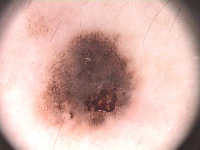</td><td>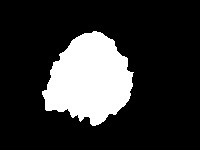</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

# Подгрузка и настройка необходимого

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from skimage.transform import resize
from skimage.io import imread
import os
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output

from torch.utils.data import DataLoader
import torch

import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wandb
!wandb login

wandb: Currently logged in as: c-nemo. Use `wandb login --relogin` to force relogin


# Датасет

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

In [ ]:
get_ipython().system_raw("unrar x drive/MyDrive/datasets/PH2Dataset.rar")

In [ ]:
!ls

drive  PH2Dataset  sample_data	wandb


1) Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

2) Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

3) Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

In [ ]:
def show_samples():

    plt.figure(figsize=(18, 6))
    
    for i in range(6):

        plt.subplot(2, 6, i+1)
        plt.axis("off")
        plt.imshow(X[i])

        plt.subplot(2, 6, i+7)
        plt.axis("off")
        plt.imshow(Y[i])

    plt.show();

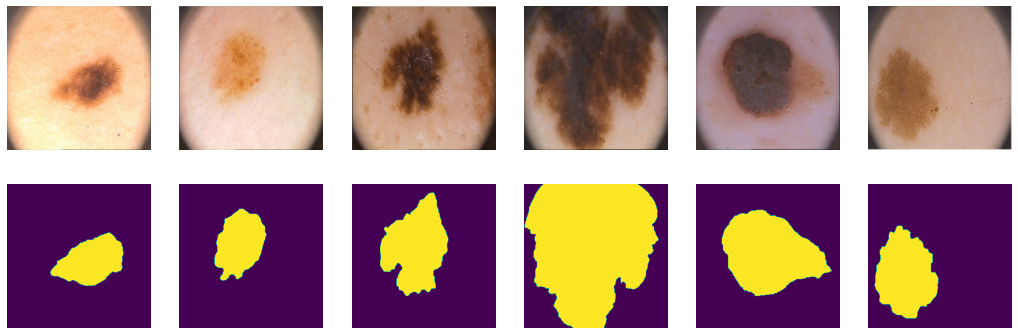

In [ ]:
show_samples()

4) Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


5) PyTorch DataLoader

In [ ]:
batch_size = 16
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

# SegNet [2 балла]

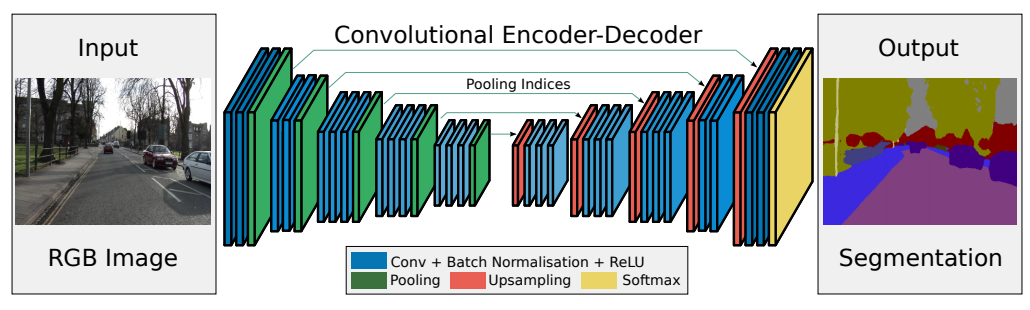

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

## Модель

In [ ]:
class SegNet(nn.Module):
    def __init__(self):

        super().__init__()

        self.enc_conv0 = nn.Sequential( nn.Conv2d(3, 64, 3, 1, 1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                       
                                        nn.Conv2d(64, 64, 1, 1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU())
        
        self.pool0 = nn.MaxPool2d(2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential( nn.Conv2d(64, 128, 3, 1, 1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(),
                                       
                                        nn.Conv2d(128, 128, 3, 1, 1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU())
        
        self.pool1 = nn.MaxPool2d(2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential( nn.Conv2d(128, 256, 3, 1, 1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                       
                                        nn.Conv2d(256, 256, 3, 1, 1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                       
                                        nn.Conv2d(256, 256, 3, 1, 1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU())
        
        self.pool2 = nn.MaxPool2d(2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential( nn.Conv2d(256, 512, 3, 1, 1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(),
                                       
                                        nn.Conv2d(512, 512, 3, 1, 1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(),
                                       
                                        nn.Conv2d(512, 512, 3, 1, 1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU())
        
        self.pool3 = nn.MaxPool2d(2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(512, 512, 1, 1)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2) # 16 -> 32

        self.dec_conv0 = nn.Sequential( nn.Conv2d(512, 512, 3, 1, 1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(),
                                       
                                        nn.Conv2d(512, 512, 3, 1, 1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(),
                                       
                                        nn.Conv2d(512, 256, 3, 1, 1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU())

        self.upsample1 = nn.MaxUnpool2d(2) # 32 -> 64

        self.dec_conv1 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                       
                                        nn.Conv2d(256, 256, 3, 1, 1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                       
                                        nn.Conv2d(256, 128, 3, 1, 1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU())

        self.upsample2 = nn.MaxUnpool2d(2) # 64 -> 128

        self.dec_conv2 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(),
                                       
                                         nn.Conv2d(128, 64, 3, 1, 1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU())

        self.upsample3 = nn.MaxUnpool2d(2) # 128 -> 256

        self.dec_conv3 = nn.Sequential( nn.Conv2d(64, 64, 1, 1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                       
                                        nn.Conv2d(64, 1, 3, 1, 1), # 3
                                        nn.BatchNorm2d(1), # 3
                                        # nn.ReLU()
                                        )

    def forward(self, x):

        # encoder
        e0, i0 = self.pool0(self.enc_conv0(x))
        e1, i1 = self.pool1(self.enc_conv1(e0))
        e2, i2 = self.pool2(self.enc_conv2(e1))
        e3, i3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # for e in (x, e0, e1, e2, e3, b):
        #     print(e.shape)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, i3))
        d1 = self.dec_conv1(self.upsample1(d0, i2))
        d2 = self.dec_conv2(self.upsample2(d1, i1))
        d3 = self.dec_conv3(self.upsample3(d2, i0))  # no activation

        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    # please don't use nn.BCELoss. write it from scratch
    # torch.sum(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))
    return (torch.clamp(y_pred, min=0) - y_pred * y_real + torch.log(1 + torch.exp(-torch.abs(y_pred)))).mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
rcParams['figure.figsize'] = (6*3, 4*3)

In [ ]:
def show_results(X_val, Y_val, Y_hat, Y_result, epoch):

    for k in range(6):

        plt.subplot(4, 6, k+1)
        plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(4, 6, k+1+6)
        plt.imshow(Y_val[k, 0], cmap='gray')
        plt.title('Target')
        plt.axis('off')

        plt.subplot(4, 6, k+1+6+6)
        plt.imshow(Y_hat[k, 0], cmap='gray')
        plt.title('Output (probabilities)')
        plt.axis('off')

        plt.subplot(4, 6, k+1+6+6+6)
        plt.imshow(Y_result[k, 0], cmap='gray')
        plt.title('Output (final)')
        plt.axis('off')

    # plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
    plt.show()

In [ ]:
def validate(model, X_val, Y_val, loss_fn, model_name, loss_name, epoch):

    model.eval()

    # predict
    X_val, Y_val = X_val.to(device), Y_val.to(device)
    Y_pred = model(X_val)

    # loss
    loss = loss_fn(Y_val, Y_pred)

    # metric score
    print(type(Y_pred), type(Y_val))
    print(Y_pred.shape, Y_val.shape)
    Y_pred = Y_pred > 0.5
    score = iou_pytorch(Y_pred, Y_val).mean().item()

    # log / append
    # append_loss(model_name, loss_name, loss)
    # append_metric(model_name, loss_name, score)

    wandb.log({"val loss": loss})
    wandb.log({"val score": score})

    # result
    Y_result = (Y_pred > 0.5).type(torch.long)

    # detach and put into cpu
    X_val = X_val.cpu().detach()
    Y_val = Y_val.cpu().detach()
    Y_pred = Y_pred.cpu().detach()
    Y_result = Y_result.cpu().detach()

    # show
    clear_output(wait=True)
    show_results(X_val, Y_val, Y_pred, Y_result, epoch)

    return score

In [ ]:
from copy import deepcopy

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, model_name, loss_name):

    run = wandb.init(project="Semantic Segmentation (test)", entity="c-nemo", reinit=True)
    wandb.run.name = f"Model {model_name} with {loss_name} loss"

    X_val, Y_val = next(iter(data_val))
    best_score = 0
    best_model = deepcopy(model)

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_score = 0

        model.train()  # train mode

        for X_batch, Y_batch in data_tr:

            # data to device
            X, Y, = X_batch.to(device), Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X)
            loss = loss_fn(Y, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)

            Y_pred = Y_pred > 0.5
            score = iou_pytorch(Y_pred, Y).mean().item()
            avg_score += score / len(data_tr)

        toc = time()
        print('loss: %f' % avg_loss)
        wandb.log({"train avg loss": avg_loss})
        wandb.log({f"train avg score": avg_score})

        val_score = validate(model, X_val, Y_val, loss_fn, model_name, loss_name, epoch)
        if val_score > best_score:
            best_score = val_score
            best_model = deepcopy(model)

    run.finish()
    return best_model


## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    sum_scores = 0
    count = 0
    for X_batch, Y_label in data:

        X_batch = X_batch.to(device)
        Y_pred = model(X_batch)
        Y_pred = Y_pred > 0.5
        Y_label = Y_label.to(device)
        score = metric(Y_pred, Y_label)
        sum_scores += score.sum().item()
        count += score.size(dim=0)

    ans = sum_scores/count
    return ans

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
torch.cuda.empty_cache()

In [ ]:
model_bce = SegNet().to(device)

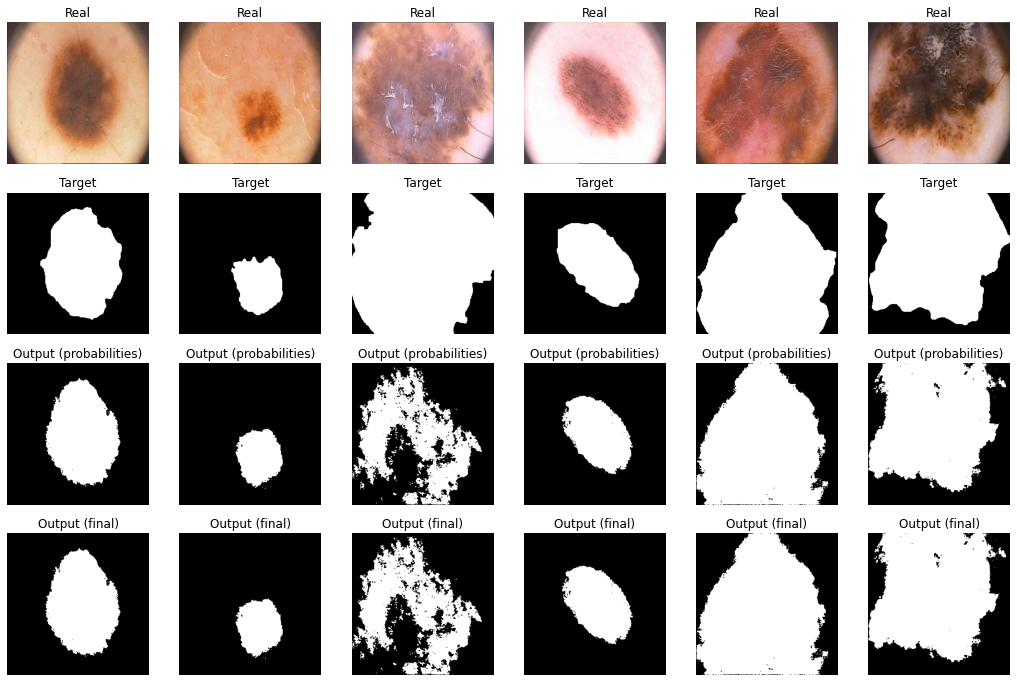

In [ ]:
max_epochs = 100
optim = torch.optim.Adam(model_bce.parameters())
model_bce = train(model_bce, optim, bce_loss, max_epochs, data_tr, data_val, 'SegNet', 'BCE')

In [ ]:
# import gc

In [ ]:
# gc.collect()

In [ ]:
score_model(model_bce, iou_pytorch, data_val), score_model(model_bce, iou_pytorch, data_ts)

(0.7060000324249267, 0.6859999918937683)

Ответьте себе на вопрос: не переобучается ли моя модель?

Ответ: Количество эпох было увеличено с 20 до 30. Переобучения не наблюдается, но сходимость есть.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


Буду использовать этот вариант Dice Loss

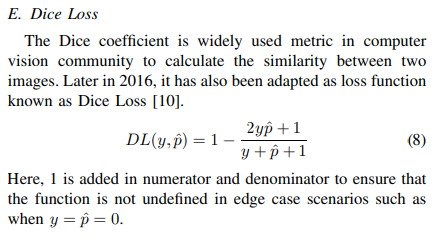

In [ ]:
def dice_loss(y_real, y_pred):
    SMOOTH = 1e-8
    y_pred = torch.sigmoid(y_pred)
    
    # Axes нужно на случай нескольких каналов
    axes = tuple(range(2,len(y_pred.shape)))
    num = 2 * torch.sum(y_pred * y_real, axes)
    den = torch.sum(y_pred + y_real, axes)
    res = 1 - torch.mean((num + SMOOTH) / (den + SMOOTH))
    return res 

Проводим тестирование:

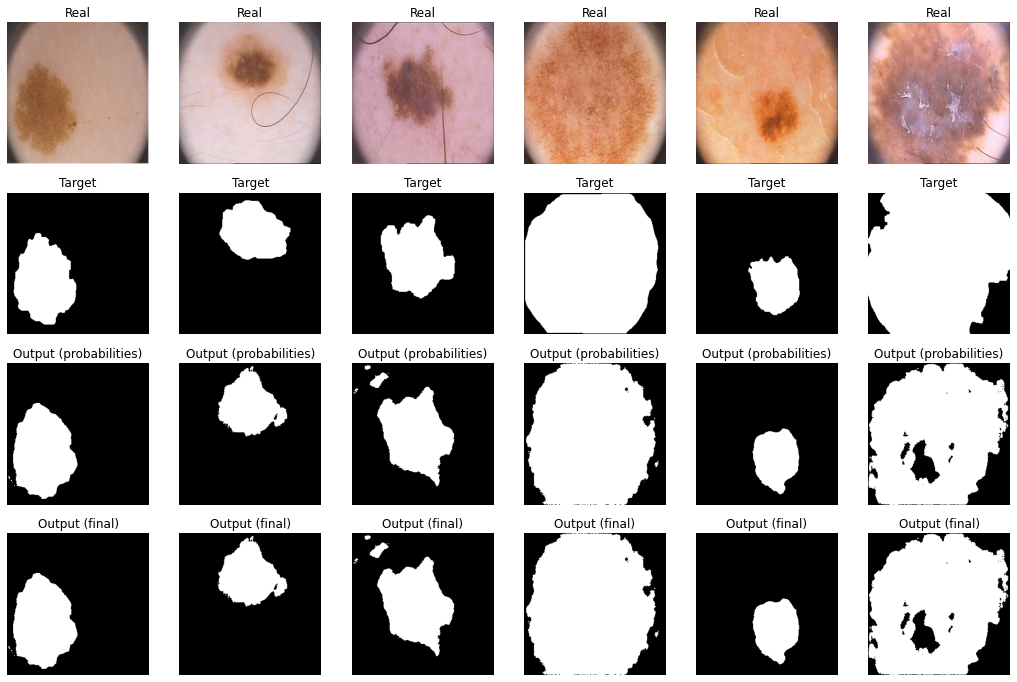

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 100
optimizer = torch.optim.Adam(model_dice.parameters())
model_dice = train(model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val, 'SegNet', 'Dice')

In [ ]:
score_model(model_dice, iou_pytorch, data_val), score_model(model_dice, iou_pytorch, data_ts)

(0.7400000119209289, 0.7560000348091126)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-5, gamma = 2):
    y_pred = torch.clamp(torch.sigmoid(y_pred), min=eps, max=1-eps)
    fl = - y_real * (1. - y_pred) ** gamma * torch.log(y_pred) - (1. - y_real) * torch.log(1. - y_pred)
    return torch.mean(fl)

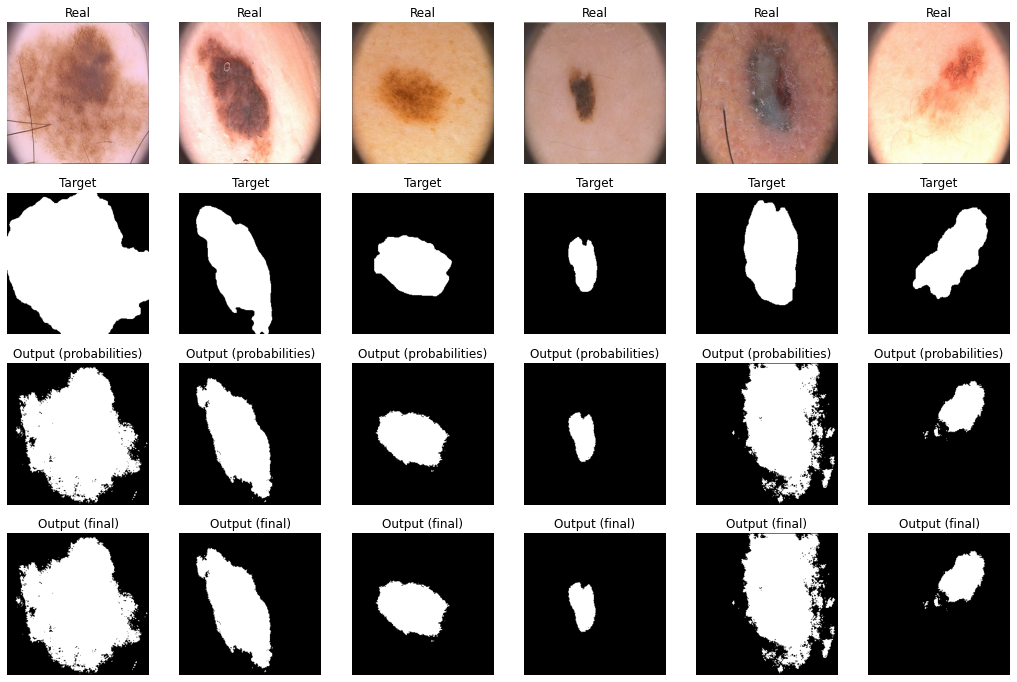

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 100
optimizer = torch.optim.Adam(model_focal.parameters())
model_focal = train(model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val, 'SegNet', 'Focal')

In [ ]:
score_model(model_focal, iou_pytorch, data_val), score_model(model_focal, iou_pytorch, data_ts)

(0.6960000383853913, 0.6760000038146973)

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

### Смешанная регуляризация
Взвешенная сумма слабой и сильной регуляризации

In [ ]:
# MSE loss
def facial_parts_fully_loss(y_pred, y_real):
    y_pred = y_pred.to(device)
    y_real = y_real.to(device)
    return torch.mean(torch.square(y_pred - y_real))

In [ ]:
# функция потерь (разреженность)
def sparsity_loss(y_pred):
    sparsity = torch.mean(torch.abs(y_pred))
    return sparsity

In [ ]:
def contiguity_loss(y_pred):
    vertical = torch.abs(y_pred[:-1] - y_pred[1:])
    horizontal = torch.abs(y_pred[:,:-1] - y_pred[:,1:])
    result = torch.zeros_like(y_pred)
    result[:-1] = vertical
    result[:,:-1] += horizontal
    return torch.mean(result)

In [ ]:
 def facial_parts_weakly_loss(y_pred, gamma=1):
    return sparsity_loss(y_pred) + gamma * contiguity_loss(y_pred)

In [ ]:
def combined_loss(y_real, y_pred, gamma = 1, alpha = 1):
    y_pred = torch.sigmoid(y_pred)
    return 0.001 * facial_parts_weakly_loss(y_pred, gamma) + alpha * facial_parts_fully_loss(y_pred, y_real)

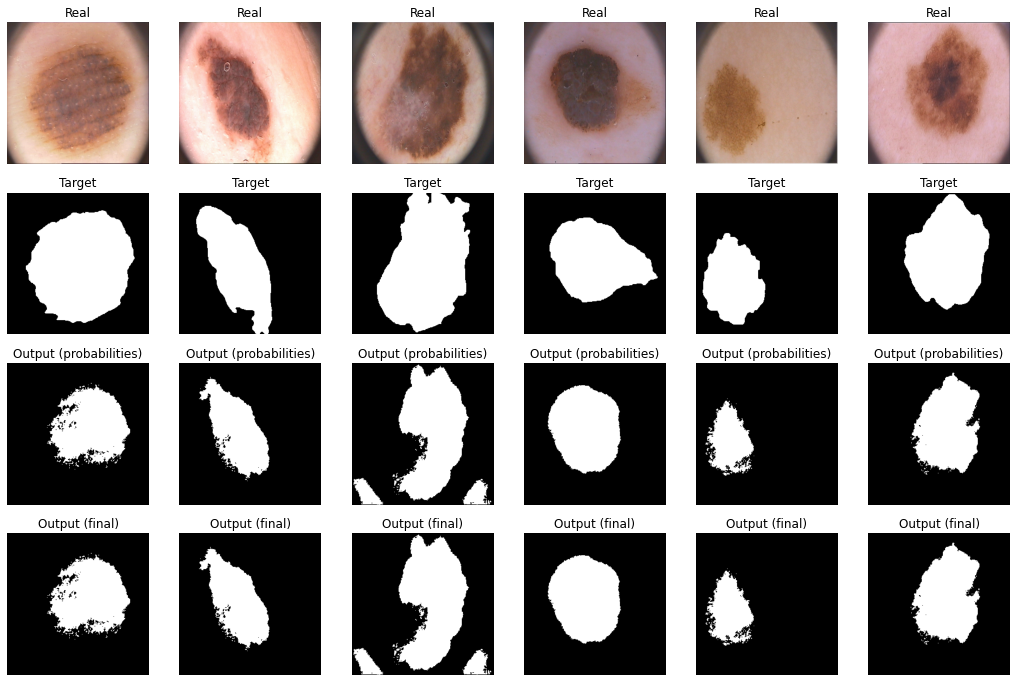

In [ ]:
model_combined = SegNet().to(device)

max_epochs = 100
optimizer = torch.optim.Adam(model_combined.parameters())
model_combined = train(model_combined, optimizer, combined_loss, max_epochs, data_tr, data_val, 'SegNet', 'Combined')

In [ ]:
score_model(model_combined, iou_pytorch, data_val), score_model(model_combined, iou_pytorch, data_ts)

(0.6760000228881836, 0.6060000205039978)

## Промежуточный вывод

На 100 эпохах:

| Loss_Fn  | Val_acc |Ts_acc |
| ------------- | ------------- |------------- |
| BCE  | 0.706  |0.686  |
| Dice  | 0.740  |**0.756 ** |
| Focal  | 0.696  |0.676  |
| Combined  | 0.676  |0.606  |

Пока что на Segnet лучше всех Dice loss.

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

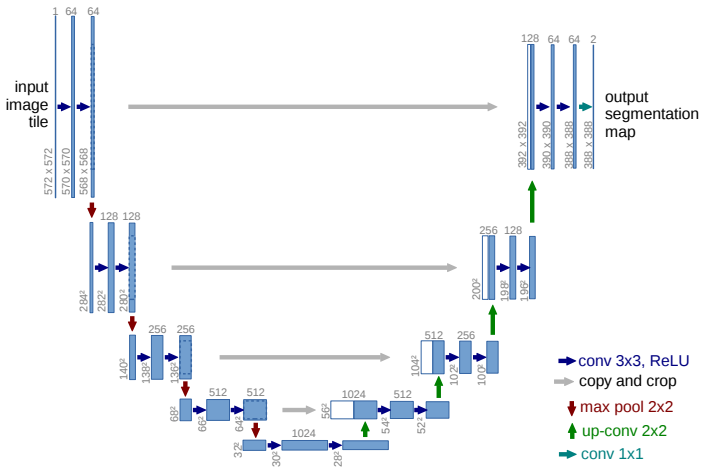

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

## Модель

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(2, 2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)  # 128 -> 64 
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)  # 64 -> 32 
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        # bottleneck
        self.bottleneck_pool = nn.MaxPool2d(2, 2)  # 32 -> 16 
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        ) 
        self.bottleneck_upconv = nn.Upsample(scale_factor=2)  # 16 -> 32
        
        # decoder (upsampling)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ) 
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        ) 
        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        ) 
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, 1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)
        
        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)
        
        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)
        
        e3 = self.enc_conv3(p2)
        p3 = self.bottleneck_pool(e3)
        
        # bottleneck
        b = self.bottleneck_upconv(self.bottleneck_conv(p3))
        
        # decoder
        d0 = self.upsample1(self.dec_conv0(torch.cat([b, e3], dim=1)))
        d1 = self.upsample2(self.dec_conv1(torch.cat([d0, e2], dim=1)))
        d2 = self.upsample3(self.dec_conv2(torch.cat([d1, e1], dim=1)))
        d3 = self.dec_conv3(torch.cat([d2, e0], dim=1))  # no activation
        return d3

## Тренировка

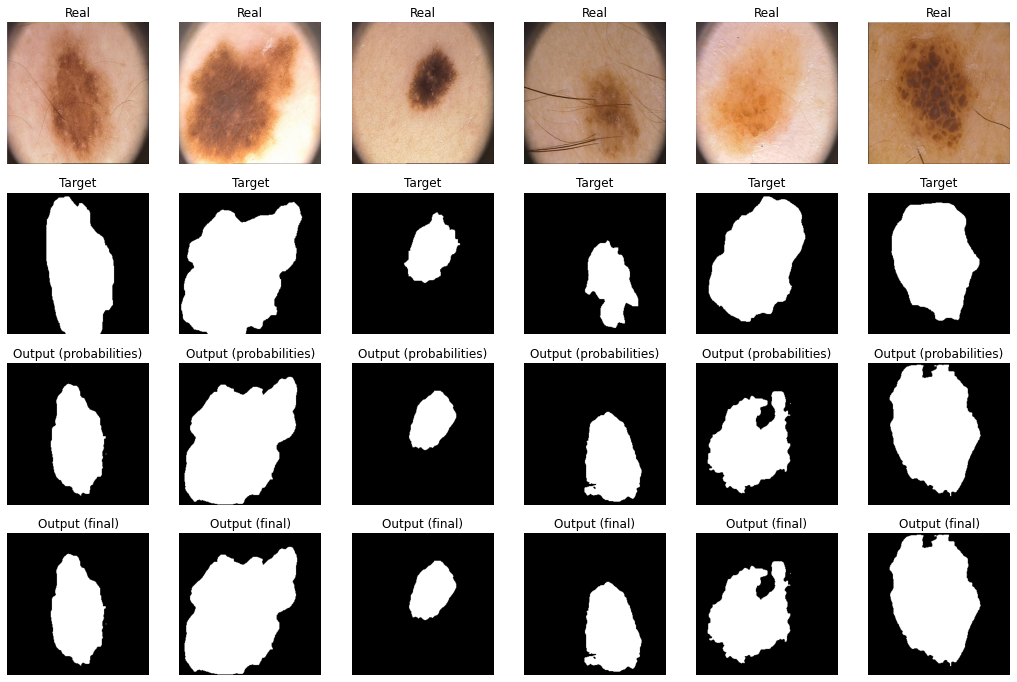

In [ ]:
unet_model = UNet().to(device)
unet_model = train(unet_model, torch.optim.Adam(unet_model.parameters()), bce_loss, 100, data_tr, data_val, 'UNet', 'BCE')

In [ ]:
score_model(unet_model, iou_pytorch, data_val), score_model(unet_model, iou_pytorch, data_ts)

(0.6940000128746032, 0.7540000247955322)

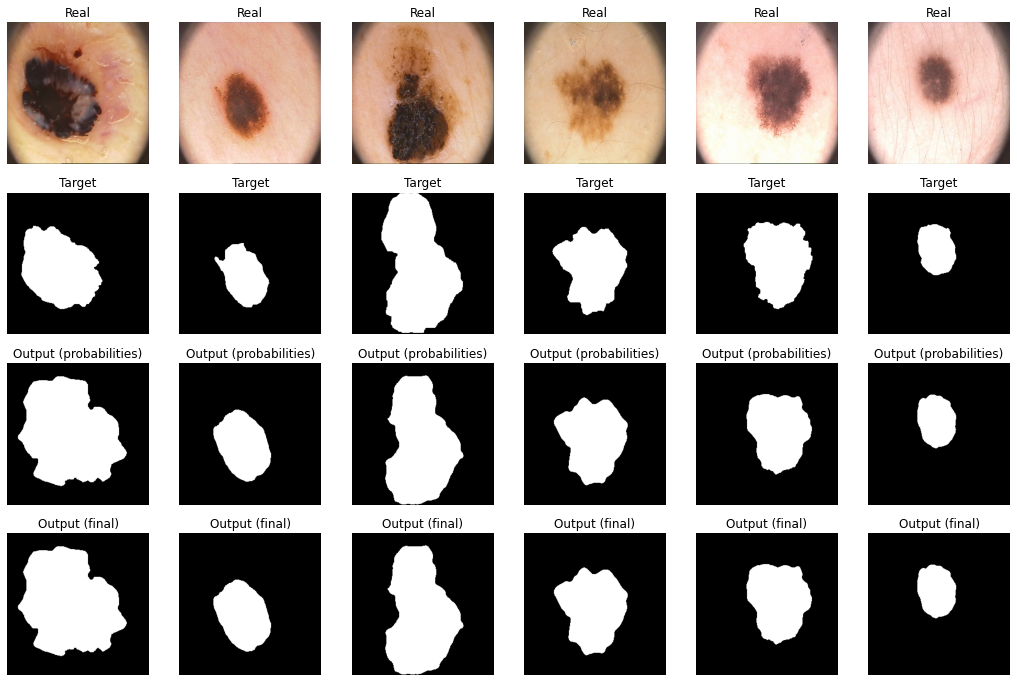

In [ ]:
unet_model = UNet().to(device)
unet_model = train(unet_model, torch.optim.Adam(unet_model.parameters()), dice_loss, 100, data_tr, data_val, 'UNet', 'Dice')

In [ ]:
score_model(unet_model, iou_pytorch, data_val), score_model(unet_model, iou_pytorch, data_ts)

(0.6980000257492065, 0.7600000047683716)

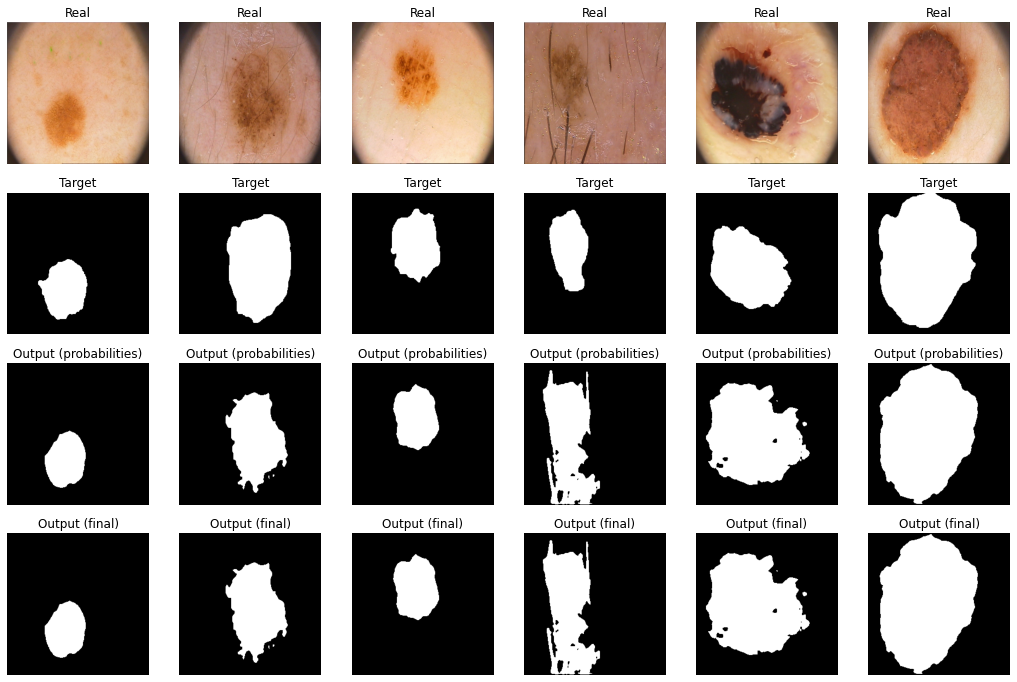

In [ ]:
unet_model = UNet().to(device)
unet_model = train(unet_model, torch.optim.Adam(unet_model.parameters()), focal_loss, 100, data_tr, data_val, 'UNet', 'Focal') 

In [ ]:
score_model(unet_model, iou_pytorch, data_val), score_model(unet_model, iou_pytorch, data_ts)

(0.6680000257492066, 0.7120000267028809)

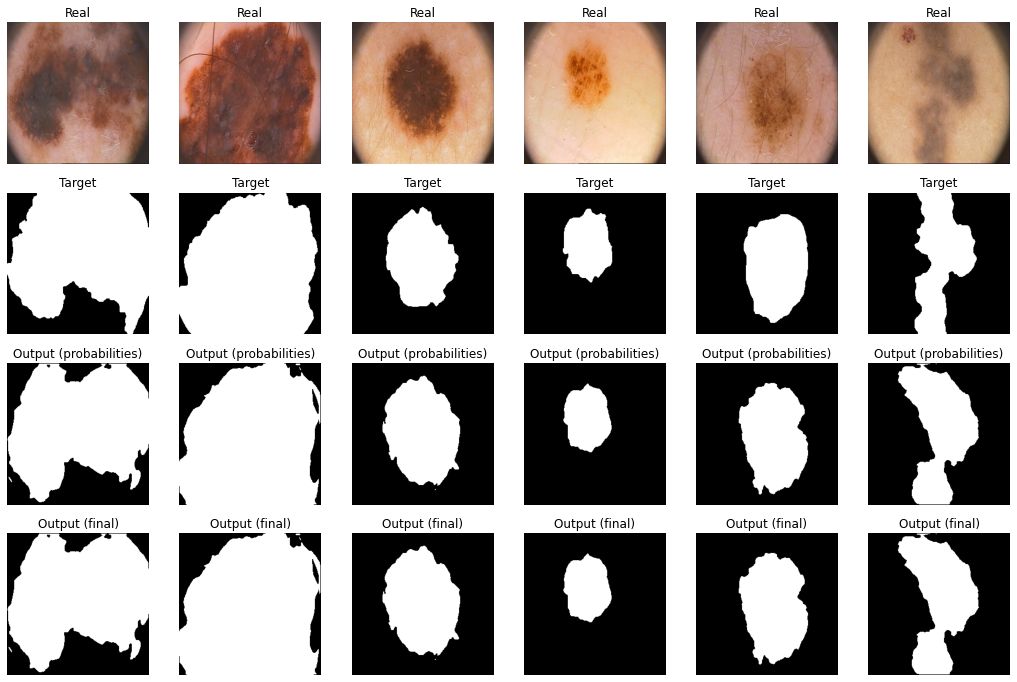

In [ ]:
unet_model = UNet().to(device)
unet_model = train(unet_model, torch.optim.Adam(unet_model.parameters()), combined_loss, 100, data_tr, data_val, 'UNet', 'Combined')

In [ ]:
score_model(unet_model, iou_pytorch, data_val), score_model(unet_model, iou_pytorch, data_ts)

(0.7340000081062317, 0.7719999885559082)

## Модель с измененным типом пулинга

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.Conv2d(64, 64, kernel_size=2, stride=2)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.Conv2d(128, 128, kernel_size=2, stride=2)  # 128 -> 64 

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.Conv2d(256, 256, kernel_size=2, stride=2)  # 64 -> 32 

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )


        # bottleneck
        self.bottleneck_pool = nn.Conv2d(512, 512, kernel_size=2, stride=2)  # 32 -> 16 
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        ) 
        self.bottleneck_upconv = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)  # 16 -> 32
        
        # decoder (upsampling)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ) 
        self.upsample1 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        ) 
        self.upsample2 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        ) 
        self.upsample3 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, 1)
        )

    def forward(self, x):
      
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)
        
        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)
        
        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)
        
        e3 = self.enc_conv3(p2)
        p3 = self.bottleneck_pool(e3)
        
        # bottleneck
        b = self.bottleneck_upconv(self.bottleneck_conv(p3))
        
        # decoder
        d0 = self.upsample1(self.dec_conv0(torch.cat([b, e3], dim=1)))
        d1 = self.upsample2(self.dec_conv1(torch.cat([d0, e2], dim=1)))
        d2 = self.upsample3(self.dec_conv2(torch.cat([d1, e1], dim=1)))
        d3 = self.dec_conv3(torch.cat([d2, e0], dim=1))  # no activation
        return d3

## Тренировка

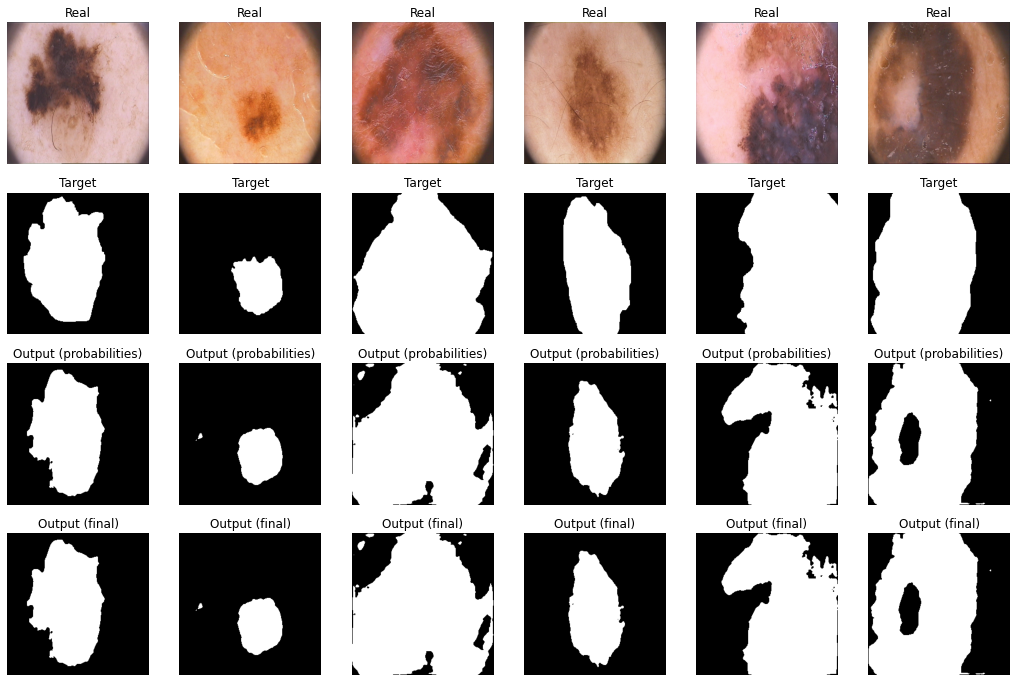

In [ ]:
unet_model = UNet2().to(device)
unet_model = train(unet_model, torch.optim.Adam(unet_model.parameters()), bce_loss, 100, data_tr, data_val, 'UNet2', 'BCE')

In [ ]:
score_model(unet_model, iou_pytorch, data_val), score_model(unet_model, iou_pytorch, data_ts)

(0.7300000154972076, 0.7460000085830688)

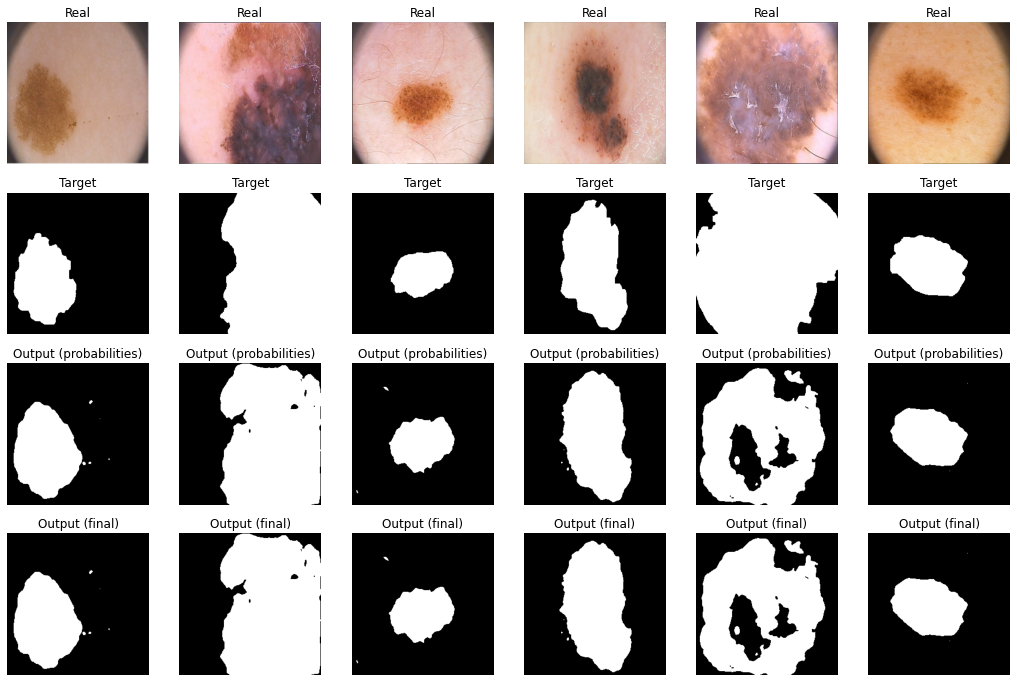

In [ ]:
unet_model = UNet2().to(device)
unet_model = train(unet_model, torch.optim.Adam(unet_model.parameters()), dice_loss, 100, data_tr, data_val, 'UNet2', 'Dice')

In [ ]:
score_model(unet_model, iou_pytorch, data_val), score_model(unet_model, iou_pytorch, data_ts)

(0.7040000247955323, 0.6820000147819519)

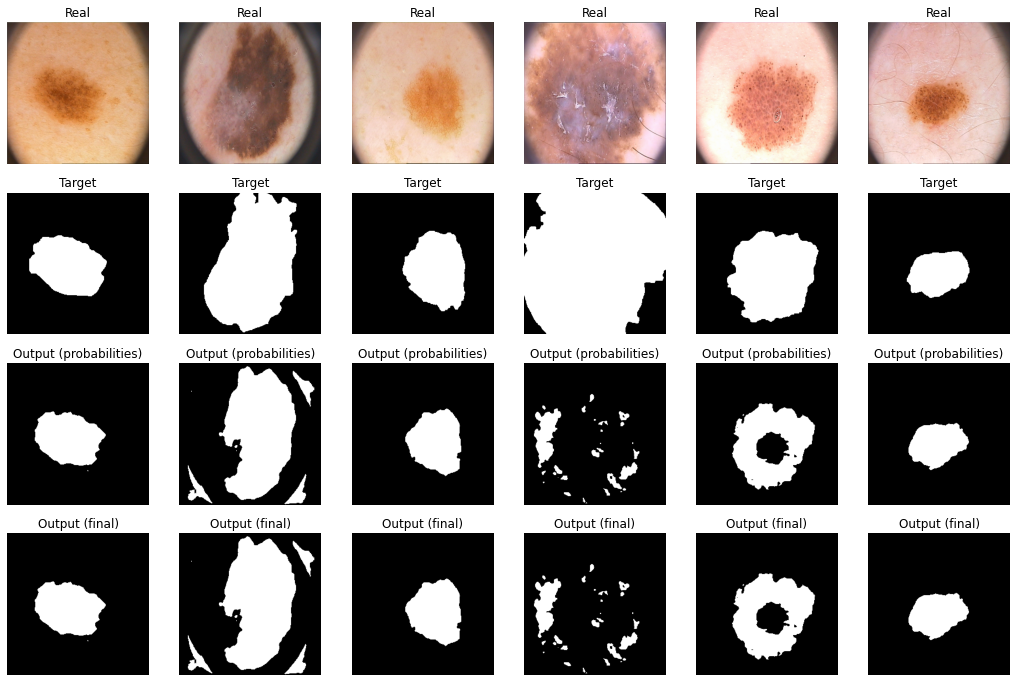

In [ ]:
unet_model = UNet2().to(device)
unet_model = unet_model = train(unet_model, torch.optim.Adam(unet_model.parameters()), focal_loss, 100, data_tr, data_val, 'UNet2', 'Focal') 

In [ ]:
score_model(unet_model, iou_pytorch, data_val), score_model(unet_model, iou_pytorch, data_ts)

(0.7340000200271607, 0.7340000200271607)

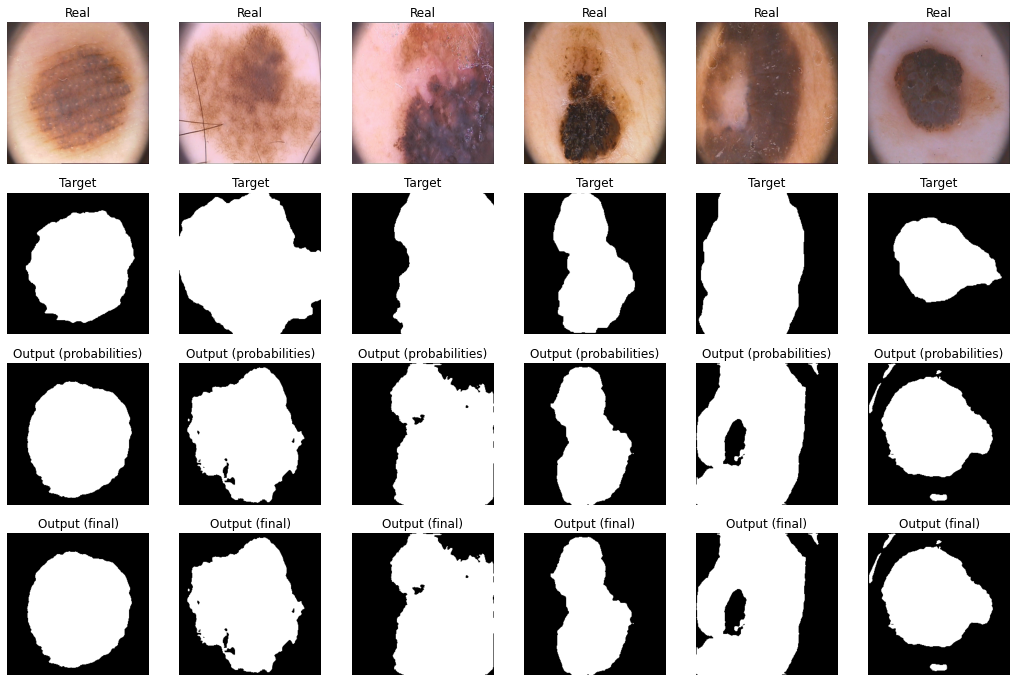

In [ ]:
unet_model = UNet2().to(device)
unet_model = train(unet_model, torch.optim.Adam(unet_model.parameters()), combined_loss, 100, data_tr, data_val, 'UNet2', 'Combined')

In [ ]:
score_model(unet_model, iou_pytorch, data_val), score_model(unet_model, iou_pytorch, data_ts)

(0.7280000281333924, 0.7520000505447387)

## Промежуточный вывод

На 100 эпохах

Unet:


| Loss_Fn  | Val_acc |Ts_acc |
| ------------- | ------------- |------------- |
| BCE  | 0.694  |0.754  |
| Dice  | 0.698  |0.760  |
| Focal  | 0.668  |0.712  |
| Combined  | 0.734  |**0.772**  |

Unet2:


| Loss_Fn  | Val_acc |Ts_acc |
| ------------- | ------------- |------------- |
| BCE  | 0.730  |0.746  |
| Dice  | 0.704  |0.682  |
| Focal  | 0.734  |0.734  |
| Combined  | 0.728  |0.752  |

Для моделей Unet и Unet2 лучший результат показывает Combined loss

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

## Отчет

В таблице приведены **score**'ы на **тестовой** выборке для **100** эпох:

| Loss \ Model | Segnet |Unet | Unet2|
| ------------- | ------------- |------------- |------------- |
| BCE  | 0.686  |0.754  |0.746  |
| Dice  | 0.756  |0.760  |0.682  |
| Focal  | 0.676  |0.712  |0.734  |
| Combined  | 0.606  |**0.772**  |0.752  |

Графики ниже были получены логированием на wandb.

##Посмотрим на графики для каждой из архитектур моделей

### Графики для Segnet

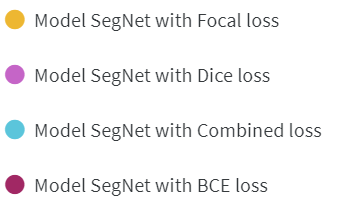

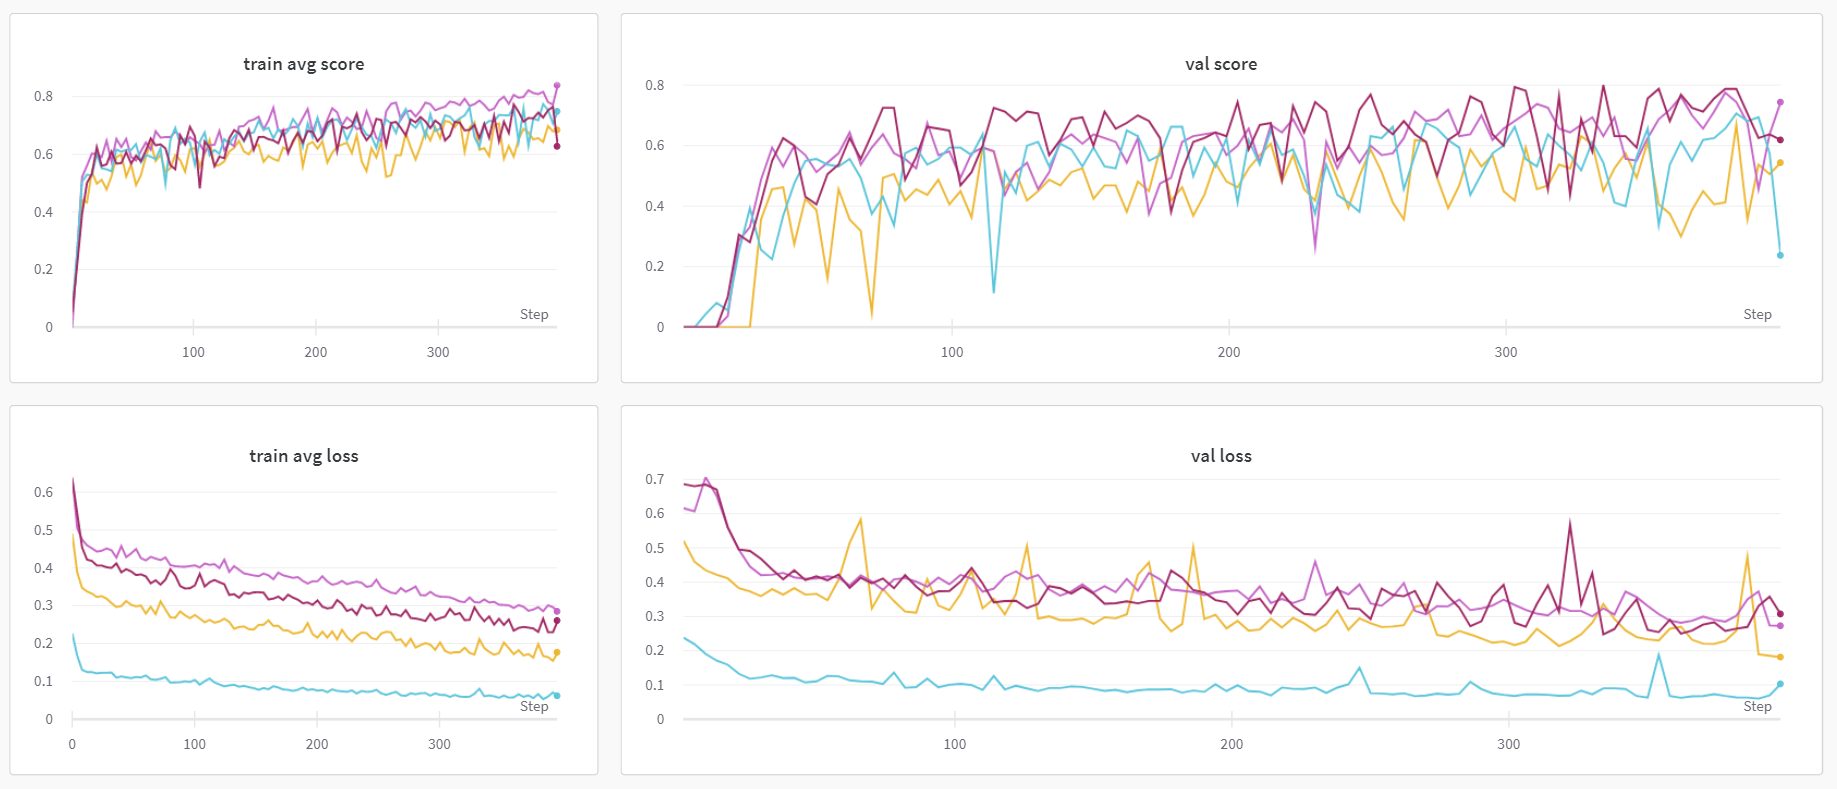

В самом конце видно начинающееся переобучение. По score'у - лучшчший результат у Dice loss

### Графики для Unet

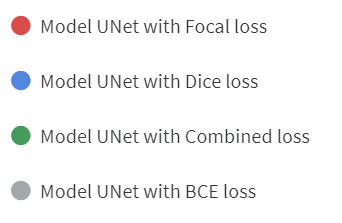

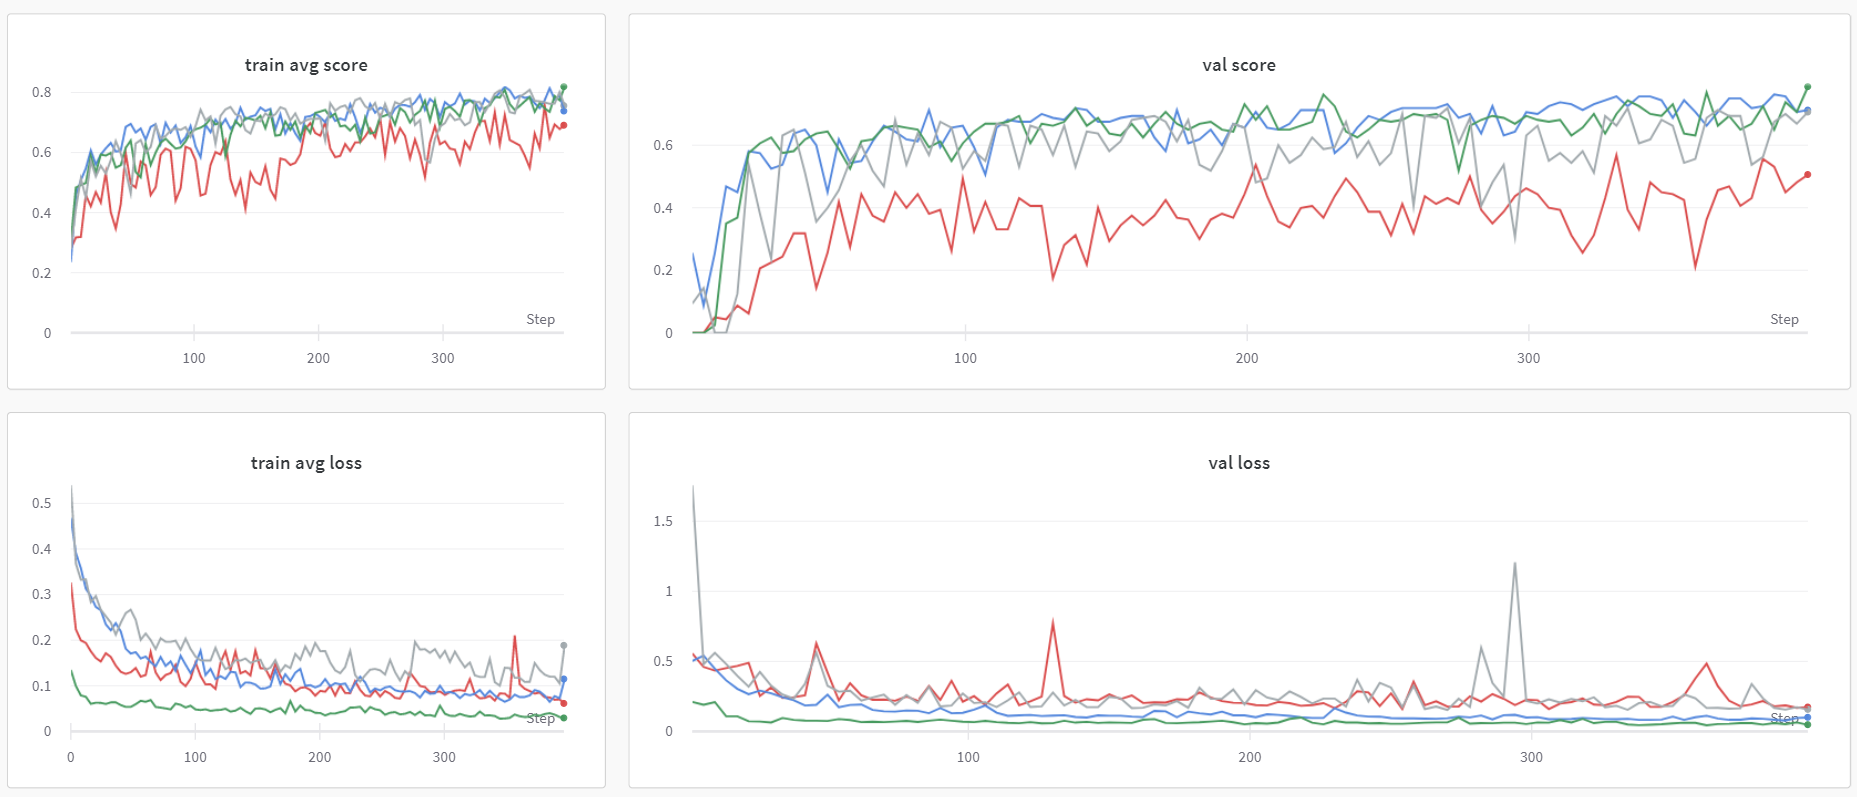

Combined loss в самлм конце ощутимо вырвался вперед без признаков переобучения. Модель с этим лоссом можно учить больше, чем на 100 эпохах.

### Графики для Unet2

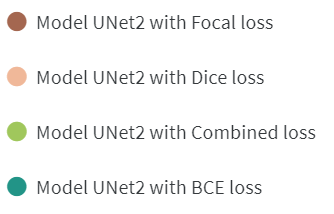

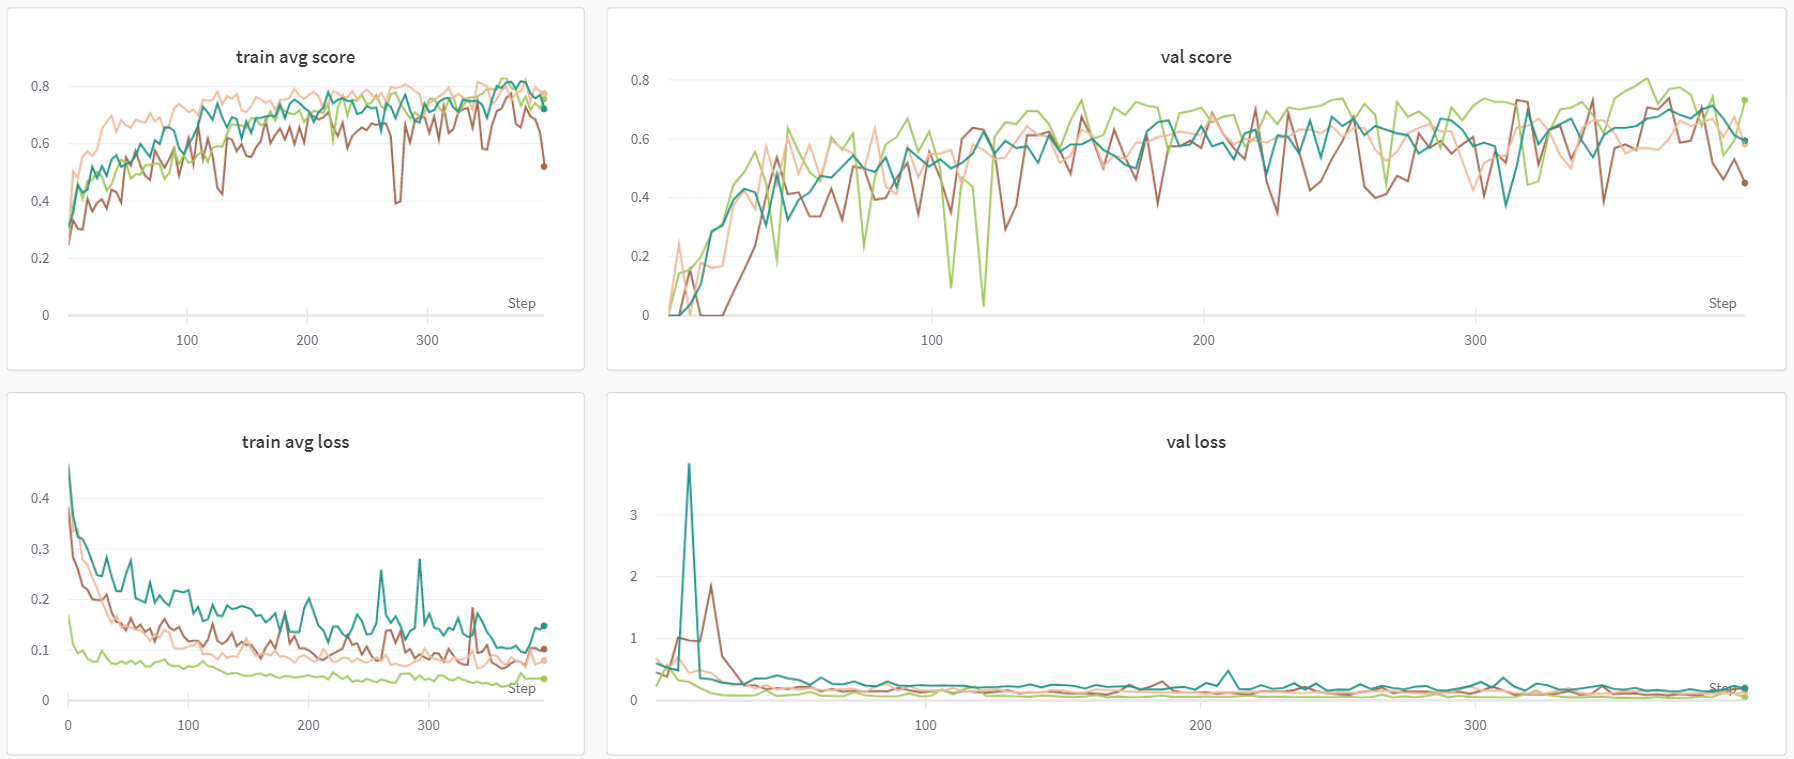

Видно начало переобучения. Лучший результат у Combined loss

## Графики для видов функций потерь

### Графики для BCE loss

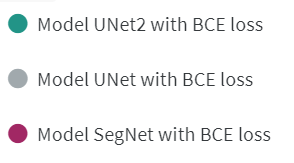

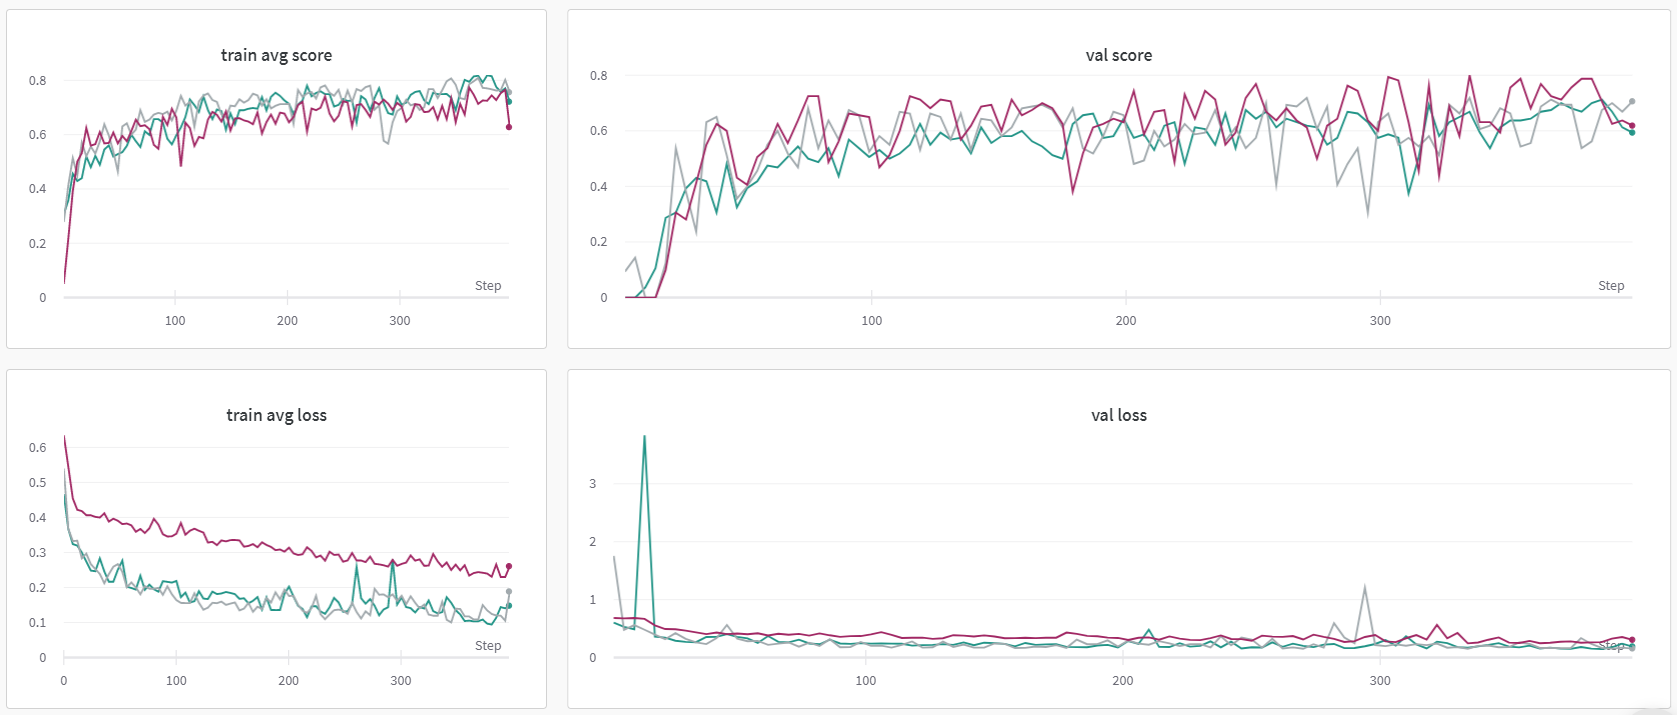

BCE показывает лучший результат у Unet'а

### Графики для Focal loss

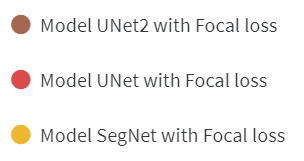

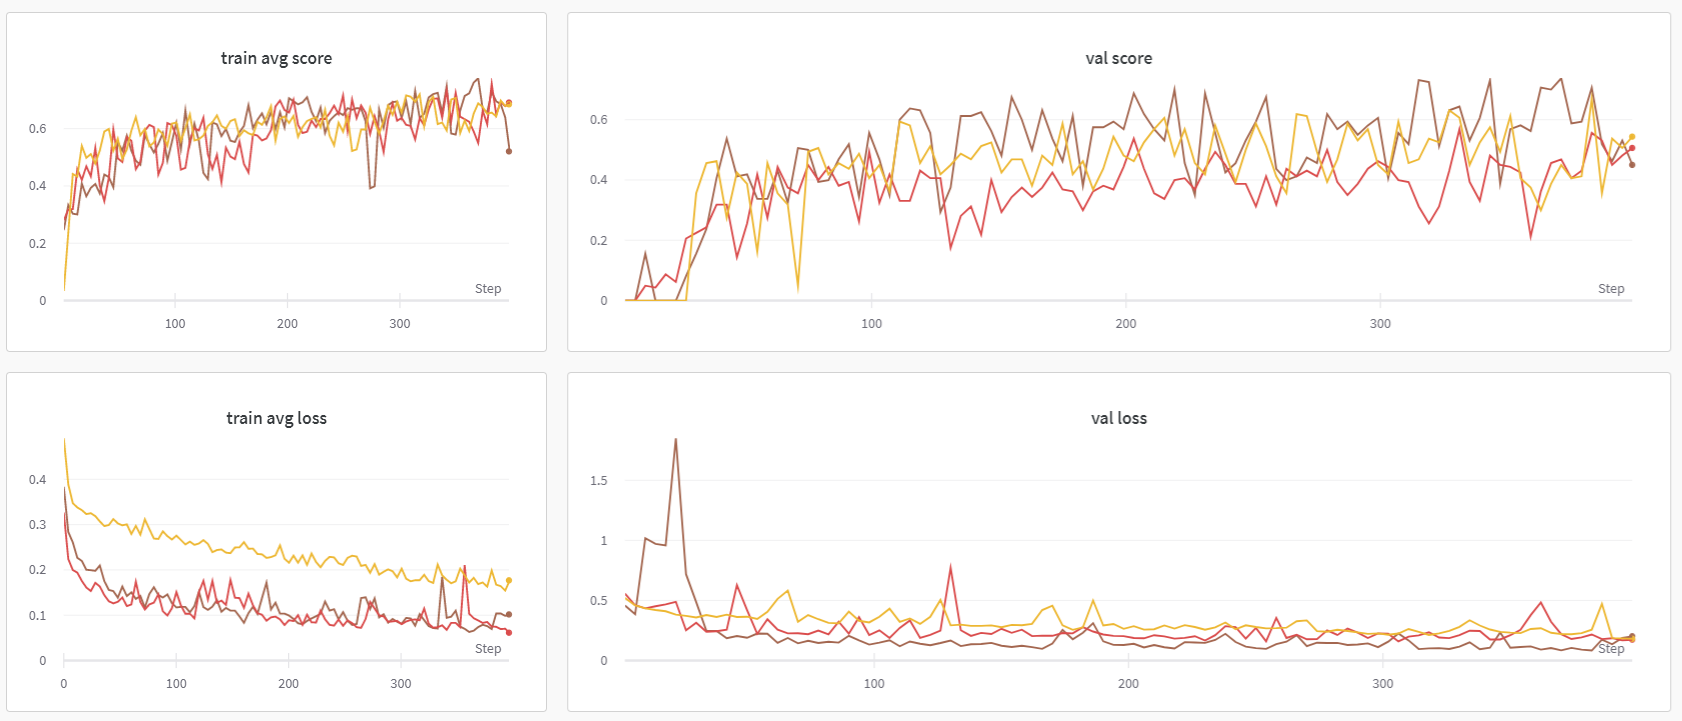

лучший результат у Unet2

### Графики для Dice loss

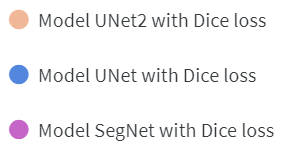

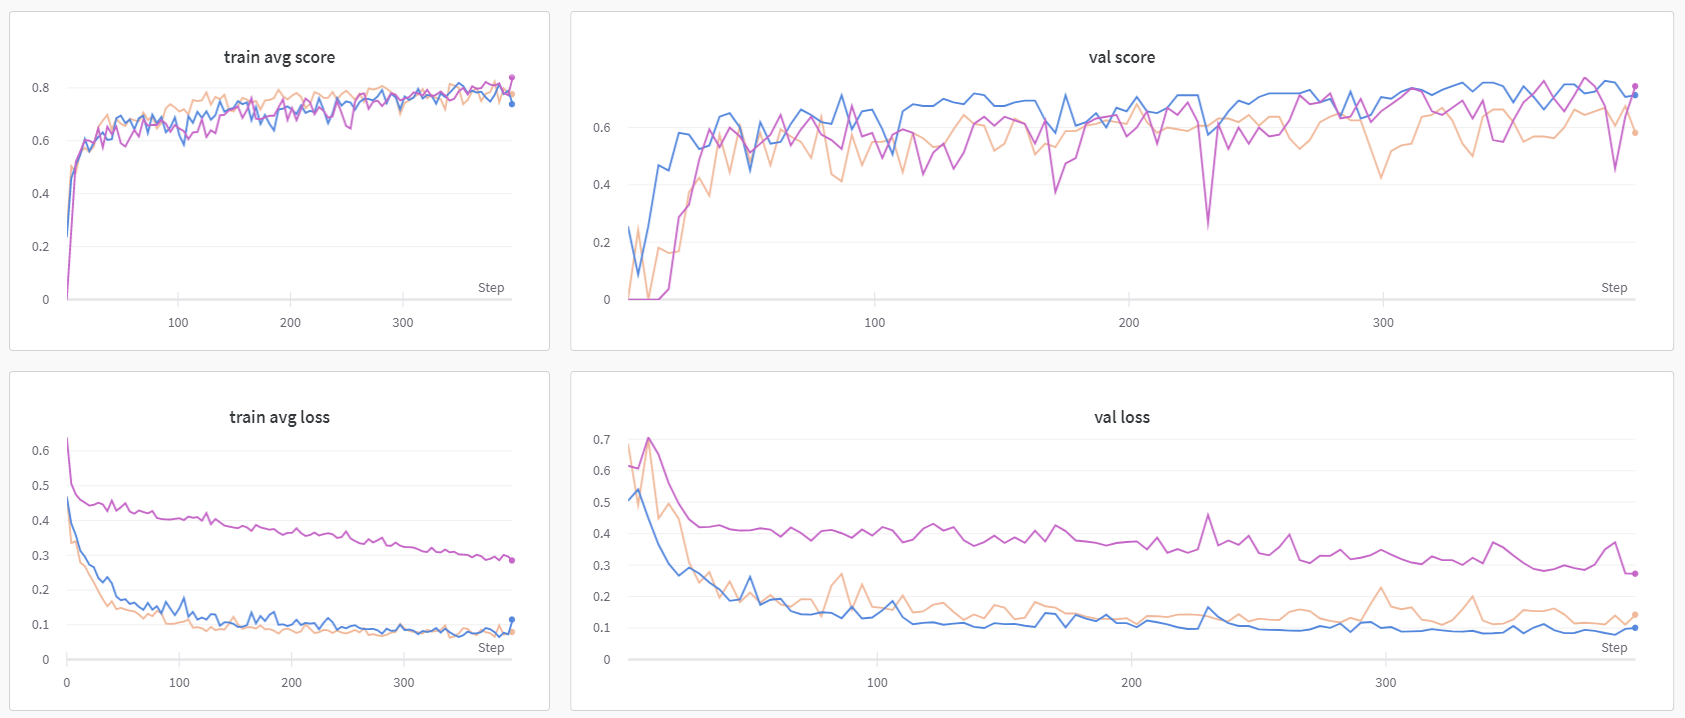

Лучший результат у Unet

### Графики для Combined loss

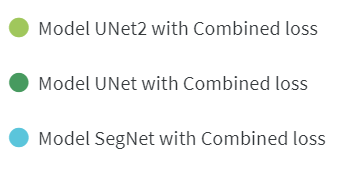

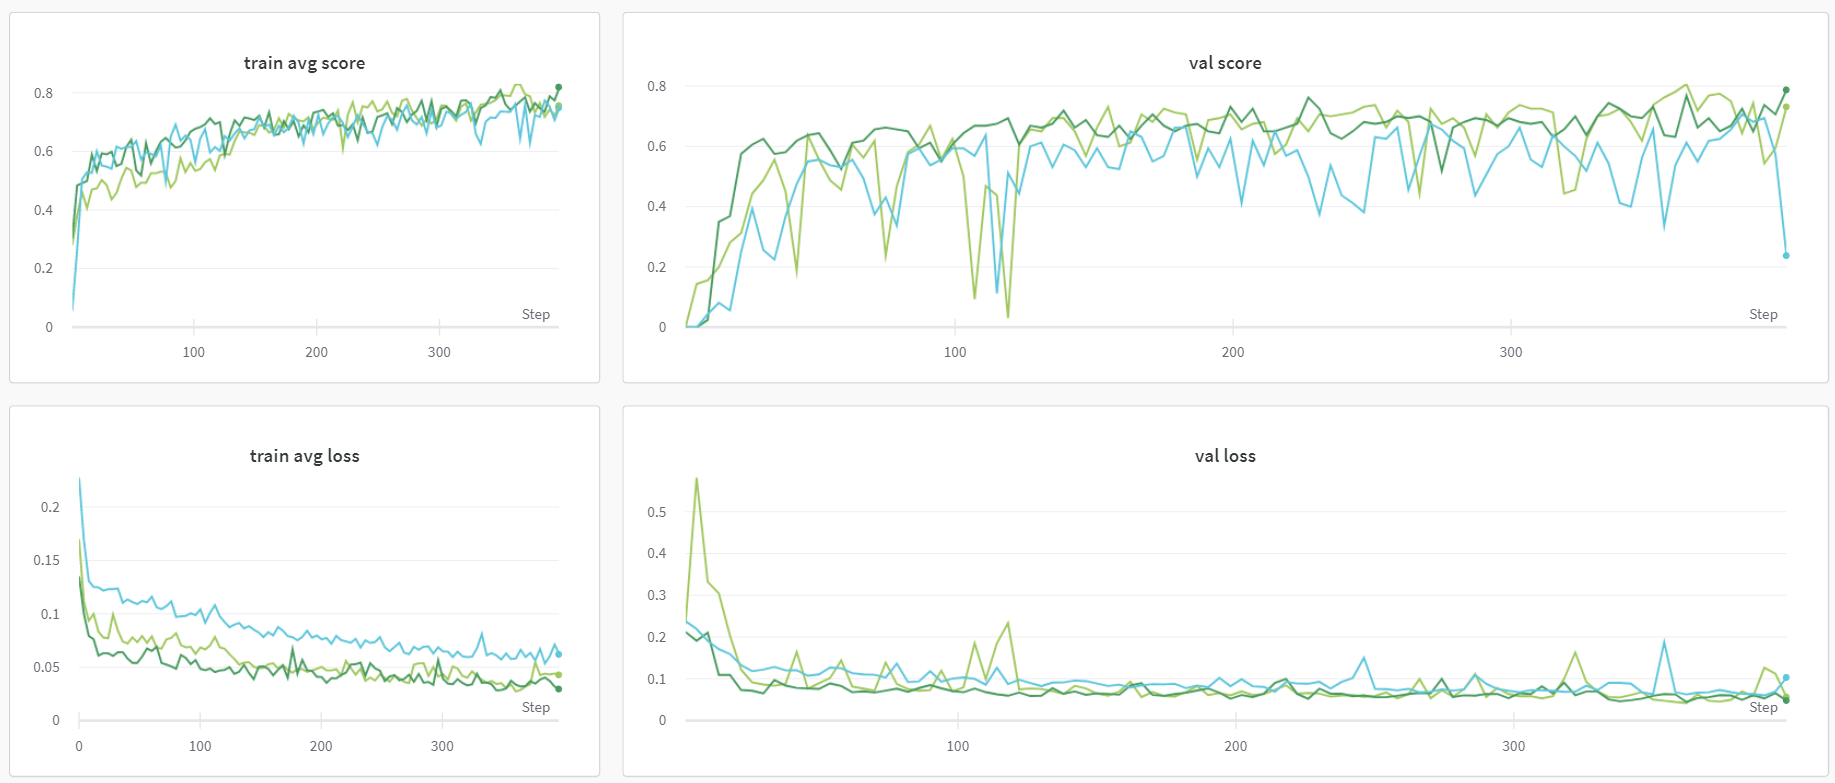

Лучший результат у Unet

## Лучший результат 0.77 на тестовой выборке:

Unet with Combined loss



### Взглянем на выходные картинки для этой модели

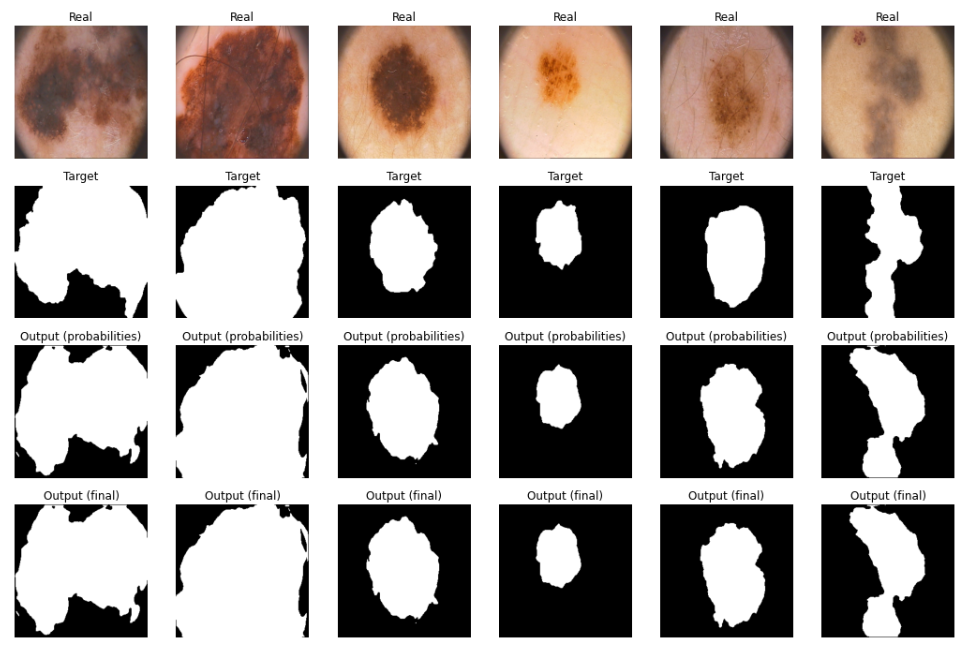

Обученная модель неплохо определяет базовую форму родинок.